In [1]:
import pandas as pd
import numpy as np
from dateutil.relativedelta import relativedelta
from datetime import datetime
from functions import *
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
df = pd.read_feather('clientes_blusol.feather')
df = df[df['situacaoCredito'] != 'Estornado']
df['primeiroVencimento'] = pd.to_datetime(df['primeiroVencimento'])
df['ultimaParcelaPaga'] = df['primeiroVencimento'] + df['nroParcelasPagas'].apply(lambda x: relativedelta(months = x - 1))
today = datetime(2023,4,10)
df['diasDesdeUltimaParcela'] = (today - df['ultimaParcelaPaga']).apply(lambda x: x.days)
df['DEFAULT'] = (df['diasDesdeUltimaParcela'] > 90) & (df['nroParcelasPagas'] != df['quantidadeParcelas'])
df = df.drop(['atividadeExercida','IDCliente','taxaaoMes','valorEmprestado','quantidadeParcelas','nroParcelasPagas','primeiroVencimento',
              'situacaoCredito','ultimaParcelaPaga','diasDesdeUltimaParcela','atividadeExercida','produto','finalidadeEmprestimo',
              'dataEmprestimo','dataLiberacao','dataCadastro','primeiroVencimento','maiorAtrasoPagas','CEP','bairro','cidade',
              'CEPEmpresa','bairroEmpresa','cidadeEmpresa'],axis = 1)

C:\Users\aruav\AppData\Local\Temp\ipykernel_7976\2963615359.py:4: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  df['ultimaParcelaPaga'] = df['primeiroVencimento'] + df['nroParcelasPagas'].apply(lambda x: relativedelta(months = x - 1))


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46752 entries, 0 to 48453
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   situacaodoImoveldeResidencia  46752 non-null  object 
 1   situacaoImoveldeAtividade     46752 non-null  object 
 2   tipodePonto                   46752 non-null  object 
 3   formacaoEscolar               46752 non-null  object 
 4   constituicao                  46752 non-null  object 
 5   rendaFamiliarMensal           46752 non-null  float64
 6   totaldasReceitas              46752 non-null  float64
 7   classificacao                 46752 non-null  object 
 8   DEFAULT                       46752 non-null  bool   
dtypes: bool(1), float64(2), object(6)
memory usage: 3.3+ MB


In [4]:
df = numerize(df)

In [5]:
x_train,x_test,y_train,y_test = train_test_split(df.drop('DEFAULT',axis = 1).values,df['DEFAULT'].values,test_size = 0.25)

In [6]:
from sklearn.metrics import mean_squared_error,make_scorer

def make_proportions(real,pred):
    pred_list = np.arange(0,1,0.01)
    scores = []
    for value in pred_list:
        pesos = np.power(1 - np.abs(pred - value),2)
        ones = pesos[real == 1].sum()
        zeros = pesos[real == 0].sum()
        scores.append(ones / zeros)
    return np.array(scores)

def metric(real,pred):
    return np.where(pred[real == 1] < 1,np.power(pred[real == 1],2),1).sum() * 100 + np.where(pred[real == 0] > 0,np.power(1 - pred[real == 0],2),1).sum()

scorer = make_scorer(metric)

In [7]:
from xgboost import XGBRegressor

Score: 35027.24621582031


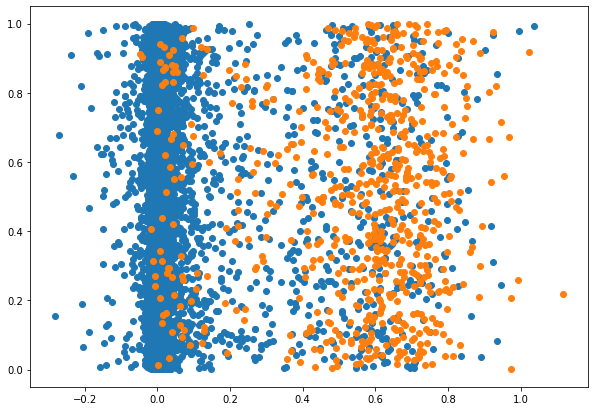

In [46]:
xgb_model = XGBRegressor(eval_metric = scorer).fit(x_train, y_train)
prediction = xgb_model.predict(x_test)
print('Score:',metric(y_test,prediction))
plt.figure(figsize = (10,7))
_ = plt.scatter(prediction[y_test == 0],np.random.rand(len(prediction[y_test == 0])))
_ = plt.scatter(prediction[y_test == 1],np.random.rand(len(prediction[y_test == 1])))

In [8]:
from imblearn.over_sampling import SMOTE

Score: 48589.245361328125


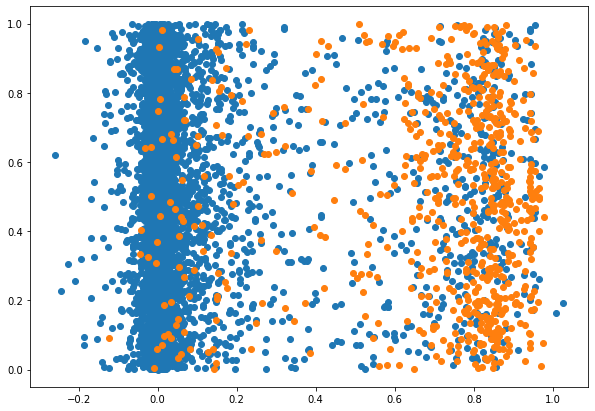

In [47]:
smote = SMOTE()
x_smote, y_smote = smote.fit_resample(x_train, y_train)
xgb_model = XGBRegressor().fit(x_smote, y_smote)
prediction = xgb_model.predict(x_test)
print('Score:',metric(y_test,prediction))
plt.figure(figsize = (10,7))
_ = plt.scatter(prediction[y_test == 0],np.random.rand(len(prediction[y_test == 0])))
_ = plt.scatter(prediction[y_test == 1],np.random.rand(len(prediction[y_test == 1])))

Score: 55451.189453125


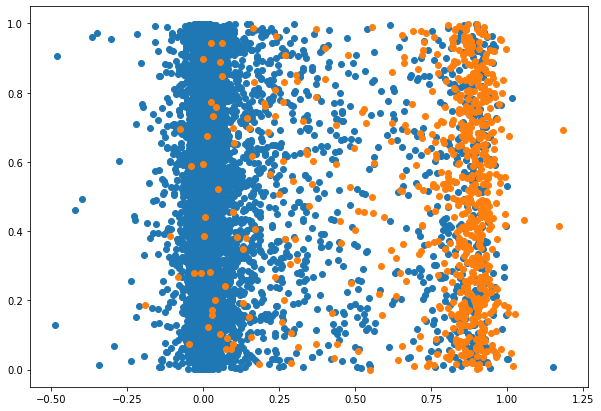

In [48]:
xgb_model = XGBRegressor(scale_pos_weight = 5).fit(x_train, y_train)
prediction = xgb_model.predict(x_test)
print('Score:',metric(y_test,prediction))
plt.figure(figsize = (10,7))
_ = plt.scatter(prediction[y_test == 0],np.random.rand(len(prediction[y_test == 0])))
_ = plt.scatter(prediction[y_test == 1],np.random.rand(len(prediction[y_test == 1])))

In [50]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

In [53]:
x,y = df.drop('DEFAULT',axis = 1).values,df['DEFAULT'].values
cv = KFold(n_splits = 4)
param_grid = {'scale_pos_weight':list(range(30,60))}
model = XGBRegressor()
grid = GridSearchCV(estimator = model, param_grid = param_grid, n_jobs = -1, cv = cv, scoring = scorer,verbose = 3)
grid_result = grid.fit(x,y)

Fitting 4 folds for each of 30 candidates, totalling 120 fits


In [54]:
grid_result.best_params_

{'scale_pos_weight': 53}

Score: 66847.18896484375


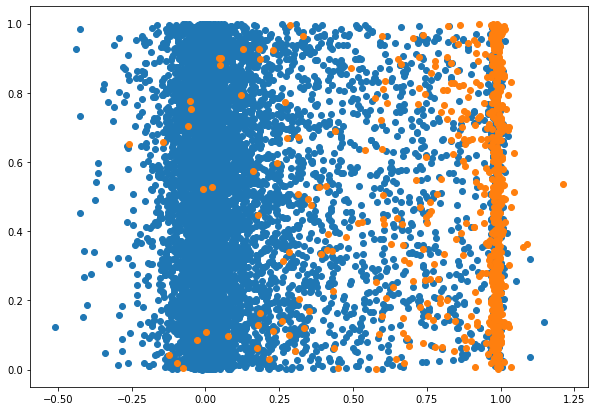

In [55]:
xgb_model = XGBRegressor(scale_pos_weight = 53).fit(x_train, y_train)
prediction = xgb_model.predict(x_test)
print('Score:',metric(y_test,prediction))
plt.figure(figsize = (10,7))
_ = plt.scatter(prediction[y_test == 0],np.random.rand(len(prediction[y_test == 0])))
_ = plt.scatter(prediction[y_test == 1],np.random.rand(len(prediction[y_test == 1])))

Score: 69429.13793945312


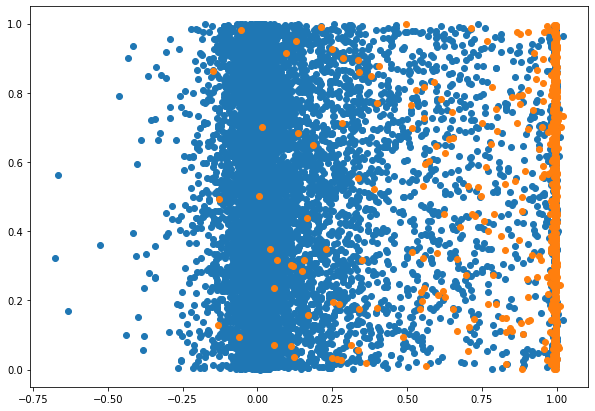

In [56]:
smote = SMOTE()
x_smote, y_smote = smote.fit_resample(x_train, y_train)
xgb_model = XGBRegressor(scale_pos_weight = 53).fit(x_smote, y_smote)
prediction = xgb_model.predict(x_test)
print('Score:',metric(y_test,prediction))
plt.figure(figsize = (10,7))
_ = plt.scatter(prediction[y_test == 0],np.random.rand(len(prediction[y_test == 0])))
_ = plt.scatter(prediction[y_test == 1],np.random.rand(len(prediction[y_test == 1])))

In [57]:
ones = len(prediction[(prediction >= 0.9) & (y_test == 1)])
all = len(prediction[prediction >= 0.9])
ones / all

0.56318407960199

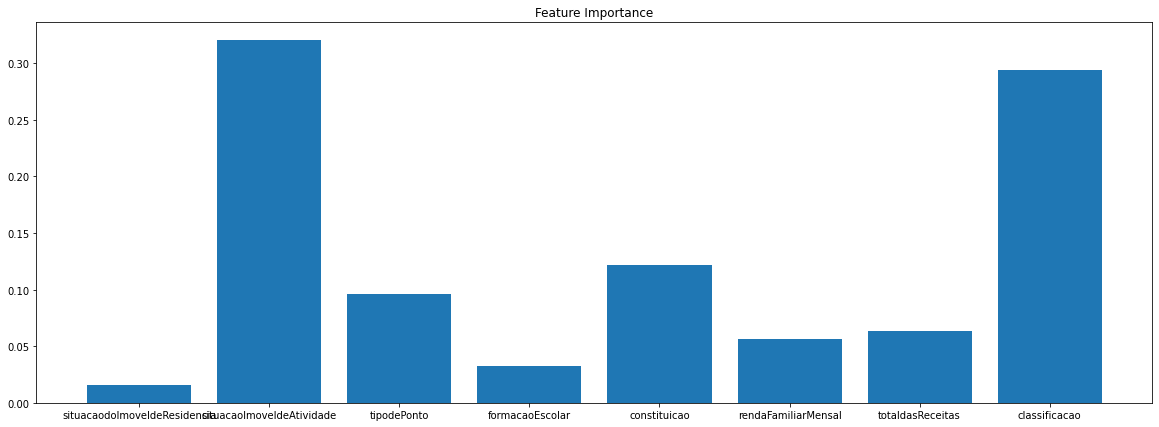

In [58]:
f = plt.figure(figsize = (20,7))
plt.bar(df.drop('DEFAULT',axis = 1).columns,xgb_model.feature_importances_)
plt.title('Feature Importance')
plt.show()

In [10]:
new = df.drop('classificacao',axis = 1)
x_train,x_test,y_train,y_test = train_test_split(new.drop('DEFAULT',axis = 1).values,new['DEFAULT'].values,test_size = 0.25)

Score: 43296.14416503906


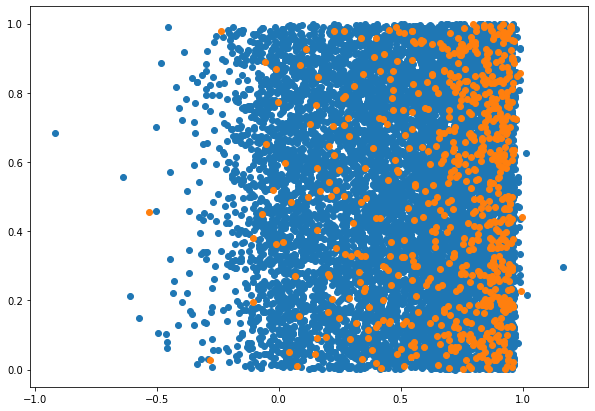

In [11]:
smote = SMOTE()
x_smote, y_smote = smote.fit_resample(x_train, y_train)
xgb_model = XGBRegressor(scale_pos_weight = 28).fit(x_smote, y_smote)
prediction = xgb_model.predict(x_test)
print('Score:',metric(y_test,prediction))
plt.figure(figsize = (10,7))
_ = plt.scatter(prediction[y_test == 0],np.random.rand(len(prediction[y_test == 0])))
_ = plt.scatter(prediction[y_test == 1],np.random.rand(len(prediction[y_test == 1])))

In [14]:
def transform(array):
    power = np.power(np.where(array < 0,0,array),2)
    return np.where(power < 1,power,1)

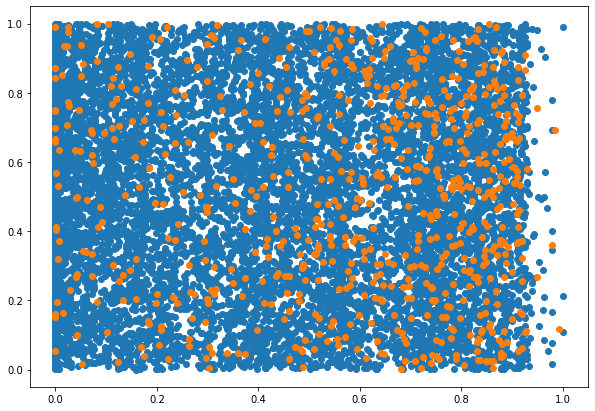

In [15]:
new_pred = transform(prediction)
plt.figure(figsize = (10,7))
_ = plt.scatter(new_pred[y_test == 0],np.random.rand(len(new_pred[y_test == 0])))
_ = plt.scatter(new_pred[y_test == 1],np.random.rand(len(new_pred[y_test == 1])))

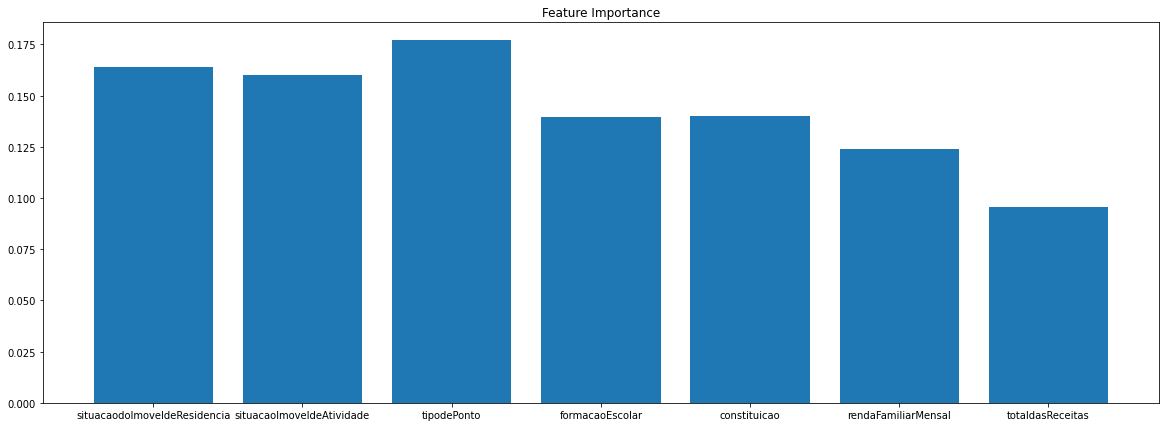

In [61]:
f = plt.figure(figsize = (20,7))
plt.bar(new.drop('DEFAULT',axis = 1).columns,xgb_model.feature_importances_)
plt.title('Feature Importance')
plt.show()